In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def getContour(img, thrshld, maxthrshld):
    """ 1. Conversion to gray scale 
        2. Binary Thresholded Mask
        3. Find Contours 
        4. Inner Contour and Outer Contour (inner circle for Inner Dia[id], Outer Circle forOuter Dia )

        Returns Inner Contour and Outer Contour
    """


    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary_img = cv2.threshold(gray, thrshld, maxthrshld, cv2.THRESH_BINARY)

    # Find all contours (not just external ones)
    contours, _ = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours (noise)
    min_area = 500  # Tune this based on your image
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    if not filtered_contours:
        return None

    # Sort contours by area
    sorted_contours = sorted(filtered_contours, key=cv2.contourArea)

    # Assuming smallest relevant area is the inner ring
    inner_contour = sorted_contours[0]

    outer_contour = max(filtered_contours, key=cv2.contourArea)

    return inner_contour, outer_contour



In [ ]:
def getCircleProperty(inner_contour, outer_contour):
    """
    1. Compute Center x, y and radius of id and od using minEnclosingCircle
    2. Returns id_radius, odradius, xin, yin, xout, yout
    """

    (center_xin, center_yin), inner_radius = cv2.minEnclosingCircle(inner_contour) #smallest enclosing circle for the  contour.
    inner_diameter = 2 * inner_radius
    print(f"Inner Diameter: {inner_diameter:.2f} pixels")

    (center_xout, center_yout), outer_radius = cv2.minEnclosingCircle(outer_contour)
    outer_diameter = 2 * outer_radius
    print(f"Outer Diameter: {outer_diameter: .2f} pixel")

    return inner_radius, outer_radius, center_xin, center_yin, center_xout, center_yout



In [ ]:
def visualize_geometry(image, inner_radius, outer_radius,
                       center_xin, center_yin, center_xout, center_yout,inner_d_mm, outer_d_mm,
                       contour=None,
                       inner_color=(0, 255, 0), outer_color=(255, 0, 0),
                       enclosing_color=(0, 0, 255), contour_color=(255, 255, 0),
                       thickness=2,):
    """
    Visualizes inner/outer circles, their diameters, a contour, and the minimum enclosing circle.

    Parameters:
        image (np.array): Input image (BGR).
        inner_radius, outer_radius (int): Radii of circles.
        center_xin, center_yin, center_xout, center_yout (int): Centers of circles.
        contour (np.array): Optional contour (Nx1x2 or Nx2).
        inner_color, outer_color, enclosing_color, contour_color (tuple): BGR colors.
        thickness (int): Drawing thickness.

        
    """
    img = image.copy()

    # Draw inner circle and diameter
    cv2.circle(img, (center_xin, center_yin), inner_radius, inner_color, thickness)
    cv2.line(img, (center_xin - inner_radius, center_yin),
             (center_xin + inner_radius, center_yin), inner_color, thickness*4)

    # Draw outer circle and diameter
    cv2.circle(img, (center_xout, center_yout), outer_radius, outer_color, thickness)
    cv2.line(img, (center_xout - outer_radius, center_yout),
             (center_xout + outer_radius, center_yout), outer_color, thickness)

    if contour is not None:
        contour = np.array(contour).astype(np.int32)

        # Ensure correct shape (Nx1x2 for OpenCV if needed)
        if contour.ndim == 2:
            contour = contour.reshape((-1, 1, 2))

        # Draw the contour
        cv2.drawContours(img, [contour], -1, contour_color, thickness)

        # Draw minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(img, center, radius, enclosing_color, thickness)
        cv2.circle(img, center, 2, enclosing_color, -1)  # center dot
    

    text_lines = [
        f"Inner Diameter: {inner_d_mm: .2f}mm",
        f"Outer Diameter: {outer_d_mm: .2f}mm"
    ]

    # Font settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_thickness = 2
    text_color = (255, 255, 255)  # white text
    bg_color = (0, 0, 0)          # black background

    # Positioning
    margin = 10
    x = img.shape[1] - margin
    y = margin + 30

    for i, line in enumerate(text_lines):
        (text_width, text_height), _ = cv2.getTextSize(line, font, font_scale, font_thickness)
        x_text = x - text_width
        y_text = y + i * (text_height + 10)

        # Draw background rectangle
        cv2.rectangle(img,
                      (x_text - 5, y_text - text_height - 5),
                      (x_text + text_width + 5, y_text + 5),
                      bg_color, -1)

        # Put text over it
        cv2.putText(img, line, (x_text, y_text),
                    font, font_scale, text_color, font_thickness, cv2.LINE_AA)

    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title("Circles, Diameters, Contour, Enclosing Circle")
    plt.axis('off')
    plt.show()

    return img


convert pxl to mm

In [ ]:
#requires pixel distance

def pixels_to_mm(pixel_measurement, pixel_distance, known_mm):
    """
    Convert a pixel measurement to millimeters.

    Parameters:
        pixel_measurement (float): Measurement in pixels to convert.
        pixel_distance (float): Pixel distance between two points of known real-world size.
        known_mm (float): Real-world distance in millimeters between the two points.

    Returns:
        float: Converted measurement in millimeters.
    """
    mm_per_pixel = known_mm / pixel_distance #obj mm / euclidean dist
    # print(mm_per_pixel)
    return pixel_measurement * mm_per_pixel

In [ ]:
def make_click_event(points, dist_container):
    def click_event(event, x, y, flags, param ):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            if len(points) == 2:
                dist = ((points[0][0] - points[1][0]) ** 2 + (points[0][1] - points[1][1]) ** 2) ** 0.5
                dist_container['value'] = dist  # store in the container
                print(f"Pixel distance: {dist:.2f}")
                cv2.line(img1, points[0], points[1], (0, 255, 0), 2)
                cv2.imshow("img1", img1)
    return click_event

In [17]:
#To find pixel distance using 2 click

# Define click handler

img1 = cv2.imread("/home/dhvani/Subhiksha/or-face/or-face-dent/s1.png")
# img1 = img1[200:1000, 700:1600]
img1 = img1[200:1000, 300:1300]

points = []
dist_container = {'value': 0.0}  # use a dict to store the value

# Show the image
cv2.imshow("img1", img1)
cv2.setMouseCallback("img1", make_click_event(points, dist_container))

# Wait for clicks
while True:
    key = cv2.waitKey(1)
    if len(points) == 2:
        break
    if key == 27:  # ESC to exit
        break

cv2.destroyAllWindows()

# Now you can access the pixel distance:
pixel_distance = dist_container['value']
print("Final pixel distance:", pixel_distance)

Pixel distance: 685.00
Final pixel distance: 685.0


In [ ]:
#main 

"""Diameter from an Image """
img1 = cv2.imread("/home/dhvani/Subhiksha/or-face/or-face-dent/s1.png")
# img1 = img1[200:1000, 700:1600]
img1 = img1[200:1000, 300:1300]


inner, outer = getContour(img1, 100,255)
inner_radius, outer_radius, center_xin, center_yin, center_xout, center_yout = getCircleProperty(inner, outer)

# Obj mm
known_mm = 60        

#pixels_to_mm
inner_d_mm = pixels_to_mm(2*inner_radius, pixel_distance, known_mm)
outer_d_mm = pixels_to_mm(2*outer_radius, pixel_distance, known_mm)

print(f"Inner diameter: {inner_d_mm:.2f} mm")
print(f"Outer diameter: {outer_d_mm:.2f} mm")

In [19]:
# two points to convert pxl to mm
#To find pixel distance using 2 click

# Define click handler
points = []
dist_container = {'value': 0.0}  # use a dict to store the value

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        if len(points) == 2:
            dist = ((points[0][0] - points[1][0]) ** 2 + (points[0][1] - points[1][1]) ** 2) ** 0.5
            dist_container['value'] = dist  # store in the container
            print(f"Pixel distance: {dist:.2f}")
            cv2.line(img1, points[0], points[1], (0, 255, 0), 2)
            cv2.imshow("img1", img1)

# Show the image
cv2.imshow("img1", img1)
cv2.setMouseCallback("img1", click_event)

# Wait for clicks
while True:
    key = cv2.waitKey(1)
    if len(points) == 2:
        break
    if key == 27:  # ESC to exit
        break

cv2.destroyAllWindows()

# Now you can access the pixel distance:
pixel_distance = dist_container['value']
print("Final pixel distance:", pixel_distance)


Pixel distance: 632.18
Final pixel distance: 632.1779812679338


Visualization of img

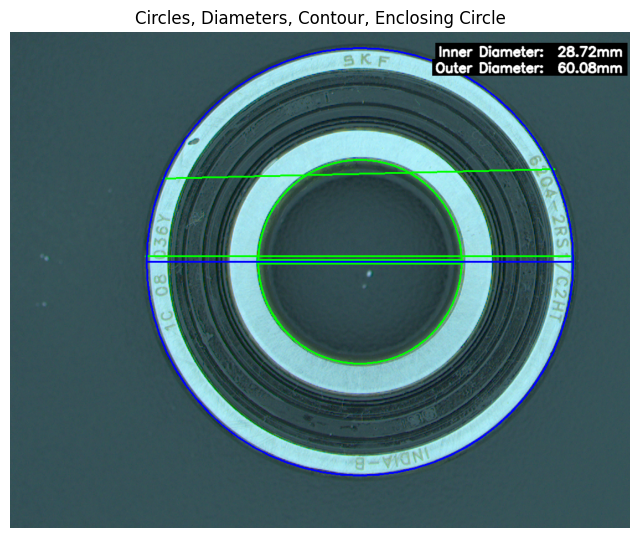

array([[[82, 79, 51],
        [82, 78, 47],
        [84, 76, 47],
        ...,
        [87, 82, 56],
        [92, 83, 56],
        [92, 83, 52]],

       [[82, 79, 49],
        [82, 79, 54],
        [84, 75, 54],
        ...,
        [87, 83, 56],
        [92, 81, 56],
        [92, 81, 57]],

       [[81, 82, 49],
        [81, 78, 54],
        [81, 74, 54],
        ...,
        [84, 83, 56],
        [93, 81, 56],
        [93, 81, 57]],

       ...,

       [[87, 83, 49],
        [87, 82, 49],
        [83, 84, 49],
        ...,
        [88, 82, 50],
        [87, 84, 50],
        [87, 84, 55]],

       [[82, 82, 49],
        [82, 83, 49],
        [84, 84, 49],
        ...,
        [86, 84, 50],
        [87, 86, 50],
        [87, 86, 55]],

       [[82, 81, 51],
        [82, 82, 52],
        [84, 82, 52],
        ...,
        [86, 85, 56],
        [87, 86, 56],
        [87, 86, 55]]], shape=(800, 1000, 3), dtype=uint8)

In [ ]:
visualize_geometry(img1, int(inner_radius), int(outer_radius), int(center_xin), int(center_yin), int(center_xout), int(center_yout), inner_d_mm, outer_d_mm)

Diameter from a Live feed

In [ ]:
while True:
    cam = cv2.VideoCapture(0)
    ret, frame = cam.read()
    if not ret:
        print("Cam not available")
    innerCntr, outerCntr = getContour(frame, 100, 255)
    idRad, odRad, xin, yin, xout, yout= getCircleProperty(innerCntr, outerCntr)

    known_mm = 60        # actual length in millimeters between of obj

    inner_d_mm = pixels_to_mm(2*idRad, pixel_distance, known_mm)
    outer_d_mm = pixels_to_mm(2*odRad, pixel_distance, known_mm)

    print(f"Inner diameter: {inner_d_mm:.2f} mm")
    print(f"Outer diameter: {outer_d_mm:.2f} mm")

    visualize_geometry(frame, idRad,odRad, xin, yin, xout, yout, inner_d_mm, outer_d_mm)

    #on key press q break
    if cv2.waitKey(1) == ord("q"):
        break
    
    cam.realese  
    cv2.destroyAllWindows()
